# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import MNIST dataset from scikit-learn
from sklearn.datasets import fetch_openml

# Import and process the data

In [ ]:
# import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# Load MNIST dataset (downloads automatically if not cached)
data = fetch_openml('mnist_784', version=1, as_frame=False)

# extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

labels = data.target.astype(int)  # Convert labels to integers
data = data.data

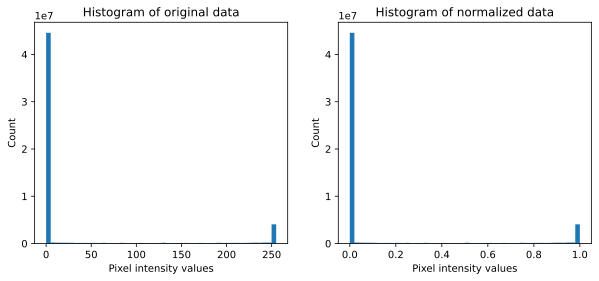

In [ ]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Create train/test groups using DataLoader

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
X                        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
batchsize                int              32
createTheMNISTNet        function         <function createTheMNISTN<...>et at 0x000001ECE087A5C0>
data                     ndarray          70000x784: 54880000 elems, type `int64`, 439040000 bytes (418.701171875 Mb)
dataBinary               ndarray          70000x784: 54880000 elems, type `float64`, 439040000 bytes (418.701171875 Mb)
dataNorm                 ndarray          70000x784: 548800

# Create the DL model

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3221, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()


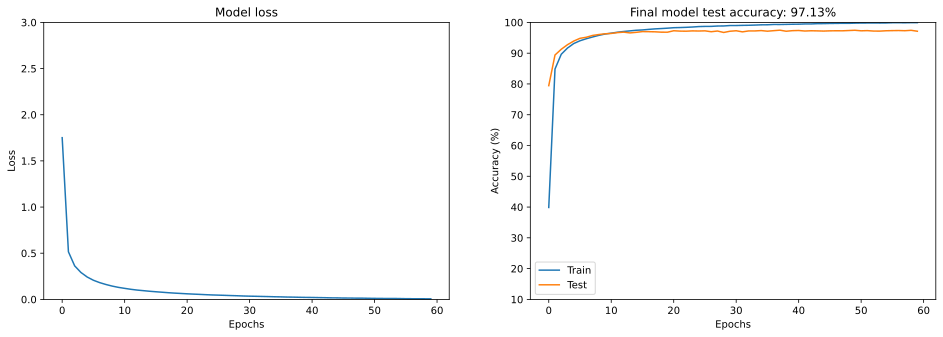

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [ ]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-3.5717e+01, -1.4911e+01, -3.5763e-07,  ..., -3.5256e+01,
         -2.0021e+01, -5.0438e+01],
        [-4.4342e+01, -1.1682e-05, -2.1097e+01,  ..., -1.1461e+01,
         -1.8101e+01, -2.4561e+01],
        [-2.4860e+01, -2.3916e+01, -2.6226e-06,  ..., -2.7634e+01,
         -1.3699e+01, -3.8352e+01],
        ...,
        [-1.3076e-04, -6.1067e+01, -2.3775e+01,  ..., -2.5345e+01,
         -3.1146e+01, -8.9425e+00],
        [-1.3780e+01, -4.0798e+01, -2.7119e+01,  ..., -1.4527e+01,
         -1.8072e+01, -9.8943e-06],
        [-4.1859e+01, -4.4107e-06, -1.8441e+01,  ..., -1.7232e+01,
         -1.2344e+01, -2.5242e+01]])

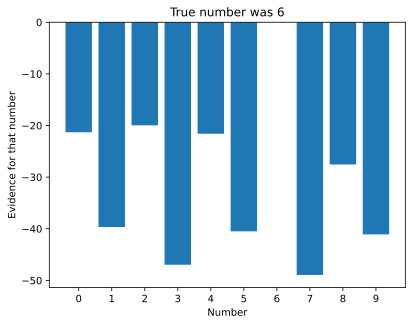

In [ ]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[   2    7  114  126  137  167  185  188  192  294  322  362  398  411
  421  430  440  443  519  531  587  588  621  694  721  747  838  958
  979 1030 1038 1045 1082 1107 1111 1116 1242 1244 1277 1310 1336 1454
 1515 1533 1683 1694 1725 1767 1779 1831 1843 1852 1898 2034 2050 2073
 2082 2173 2202 2259 2304 2308 2364 2381 2436 2463 2526 2539 2608 2649
 2701 2709 2729 2764 2779 2789 2857 2927 2934 2950 3091 3109 3169 3185
 3191 3220 3242 3253 3311 3348 3413 3414 3419 3429 3474 3500 3555 3594
 3600 3611 3623 3626 3648 3664 3721 3726 3758 3764 3802 3822 3823 3827
 3874 3932 3966 4058 4072 4143 4266 4315 4336 4363 4367 4378 4412 4423
 4443 4444 4450 4460 4462 4481 4488 4500 4572 4573 4579 4597 4604 4611
 4623 4653 4708 4755 4766 4782 4842 4882 4913 4950 4966 5004 5018 5023
 5040 5157 5190 5218 5219 5229 5234 5302 5411 5474 5475 5536 5555 5603
 5638 5725 5771 5776 5855 5868 5880 5885 5903 5945 5995 6074 6107 6157
 6181 6238 6246 6259 6301 6346 6352 6415 6416 6492 6530 6656 6668 6699
 6754 

C:\Users\marco\AppData\Local\Temp\ipykernel_30264\2747607007.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


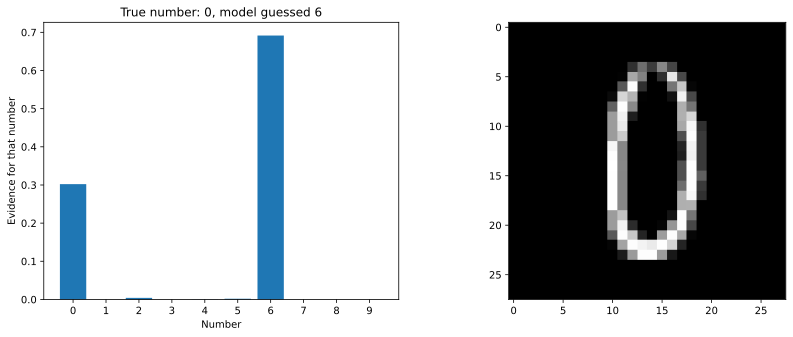

In [ ]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 